<a href="https://colab.research.google.com/github/bs3537/DS-Unit-4-Sprint-3-Deep-Learning/blob/master/164_layer_InceptionResNetV2_Transfer_Learning_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT LIBRARIES

In [0]:
import os
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


DATASET_PATH  = '/content/drive/My Drive/Lambda DS_Unit 4 Deep Learning/CNNs/data'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 2
BATCH_SIZE    = 8  
FREEZE_LAYERS = 2  


datagen = ImageDataGenerator()

train_batches = datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  class_mode='categorical',
                                                  batch_size=BATCH_SIZE)


valid_batches = datagen.flow_from_directory(DATASET_PATH + '/validation',
                                                  target_size=IMAGE_SIZE,
                                                  class_mode='categorical',
                                                  batch_size=BATCH_SIZE)

# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')




Found 457 images belonging to 2 classes.
Found 165 images belonging to 2 classes.
****************
Class #0 = forest
Class #1 = mountain
****************


In [4]:



net = InceptionResNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output

x = Flatten()(x)
x = Dropout(0.2)(x)



output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)

for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False

for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

net_final.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='auto', min_delta=0.001, factor=0.1, patience=1) 

TRAIN AND VALIDATE ON DATA

In [6]:
NUM_EPOCHS = 20

BATCH_SIZE    = 8 

stop = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, patience=3, verbose=1)
filepath="/content/drive/My Drive/Lambda DS_Unit 4 Deep Learning/CNNs/data/best_inceptionresnetV2_model_scenes_assignment_imagegeneratorv20.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_freq='epoch')

hist = net_final.fit(
        train_batches,
        epochs=NUM_EPOCHS,
        validation_data=valid_batches,
        verbose=1,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
        callbacks=[stop, checkpoint, rlrop],
        validation_steps = valid_batches.samples // BATCH_SIZE)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 1.1192 - accuracy: 0.8728
Epoch 00001: val_loss improved from inf to 6121.71533, saving model to /content/drive/My Drive/Lambda DS_Unit 4 Deep Learning/CNNs/data/best_inceptionresnetV2_model_scenes_assignment_imagegeneratorv20.hdf5
57/57 [==============================] - 20s 359ms/step - loss: 1.1192 - accuracy: 0.8728 - val_loss: 6121.7153 - val_accuracy: 0.6938 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 1.3636 - accuracy: 0.9310
Epoch 00002: val_loss improved from 6121.71533 to 251.83505, saving model to /content/drive/My Drive/Lambda DS_Unit 4 Deep Learning/CNNs/data/best_inceptionresnetV2_model_scenes_assignment_imagegeneratorv20.hdf5
57/57 [==============================] - 16s 283ms/step - loss: 1.3636 - accuracy: 0.9310 - val_loss: 251.8351 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9800
Epoch

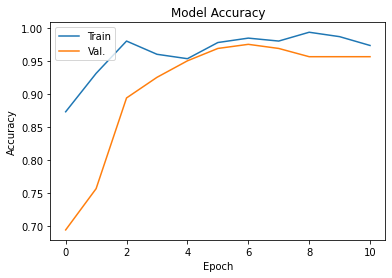

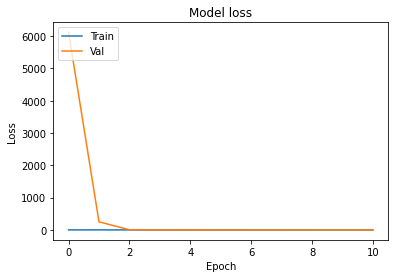

In [20]:
# Plot training & validation accuracy and loss

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val.'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

PREDICT ON TEST IMAGES DOWNLOADED FROM THE INTERNET

forest


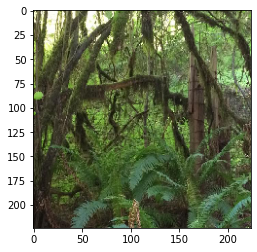

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np
img = image.load_img("/content/drive/My Drive/Lambda DS_Unit 4 Deep Learning/CNNs/test_forest_mountain/fence-line.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from tensorflow.keras.models import load_model
saved_model = load_model(filepath)
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("forest")
else:
    print('mountain')

forest


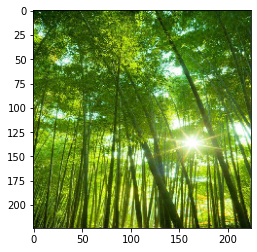

In [23]:
img = image.load_img("/content/drive/My Drive/Lambda DS_Unit 4 Deep Learning/CNNs/test_forest_mountain/5skZyv.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
saved_model = load_model(filepath)
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("forest")
else:
    print('mountain')

mountain


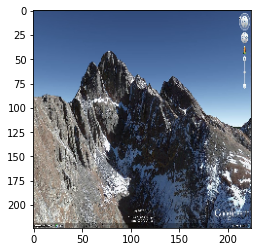

In [24]:
img = image.load_img("/content/drive/My Drive/Lambda DS_Unit 4 Deep Learning/CNNs/test_forest_mountain/KvUqiGqklghDH_ESBWIV_E1RuN-8ct_ARH7UV23Tpm4.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
saved_model = load_model(filepath)
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("forest")
else:
    print('mountain')

forest


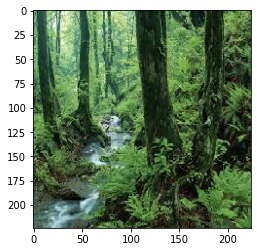

In [25]:
img = image.load_img("/content/drive/My Drive/Lambda DS_Unit 4 Deep Learning/CNNs/test_forest_mountain/images.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
saved_model = load_model(filepath)
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("forest")
else:
    print('mountain')

mountain


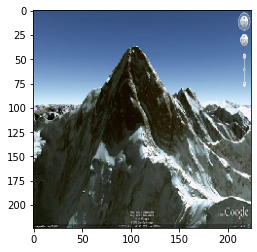

In [26]:
img = image.load_img("/content/drive/My Drive/Lambda DS_Unit 4 Deep Learning/CNNs/test_forest_mountain/2k2.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
saved_model = load_model(filepath)
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("forest")
else:
    print('mountain')

mountain


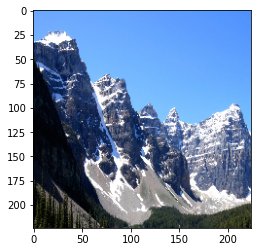

In [27]:
img = image.load_img("/content/drive/My Drive/Lambda DS_Unit 4 Deep Learning/CNNs/test_forest_mountain/bg_wed_1280x800.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
saved_model = load_model(filepath)
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("forest")
else:
    print('mountain')

100% accuracy on the test images